# Prétraitement

## Redimension

In [14]:
import os
from PIL import Image

# Dossier de base à explorer
base_folders = [
    "/Users/kevinroualec/Desktop/imgp8/leftImg8bit/train", 
    "/Users/kevinroualec/Desktop/imgp8/gtFine/train"
]

# Dossier de sauvegarde des images redimensionnées
output_folder = "/Users/kevinroualec/Desktop/imgp8/resized_images"

# Créer le dossier de sauvegarde s'il n'existe pas
os.makedirs(output_folder, exist_ok=True)

# Fonction pour vérifier si le fichier suit la structure dans gtFine
def is_gtfine_image(filename):
    return filename.lower().endswith('gtfine_instanceids.png')

# Dictionnaire pour stocker les images groupées par leur préfixe
grouped_images = {}

# Exploration des dossiers
for base_folder in base_folders:
    
    # Liste tous les fichiers dans le dossier de base
    files = os.listdir(base_folder)

    # Liste des sous-dossiers dans chaque dossier de base
    subfolders = [f for f in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, f))]

    # Exploration des sous-dossiers
    for subfolder in subfolders:
        # Chemin complet du sous-dossier
        subfolder_path = os.path.join(base_folder, subfolder)
        
        # Liste des fichiers dans ce sous-dossier
        if base_folder == "/Users/kevinroualec/Desktop/imgp8/gtFine/train":
            # Si c'est le dossier gtFine, on filtre pour ne garder que les fichiers avec la structure spécifique
            image_files = [f for f in os.listdir(subfolder_path) if is_gtfine_image(f)]
        else:
            # Sinon on prend tous les fichiers image
            image_files = [f for f in os.listdir(subfolder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
        
        # Vérifier si des images ont été trouvées
        if len(image_files) == 0:
            print(f"Aucune image trouvée dans le sous-dossier {subfolder}")
        
        for image_file in image_files:
            # Extraire le préfixe (partie avant "_leftImg8bit.png" ou "_gtFine_instanceIds.png")
            prefix = "_".join(image_file.split('_')[:3])
            
            # Ajouter l'image dans le dictionnaire, en la regroupant par son préfixe
            if prefix not in grouped_images:
                grouped_images[prefix] = {'left_image': None, 'gtfine_image': None}

            # Ajouter l'image selon son type (left image ou gtFine image)
            if 'leftImg8bit' in image_file:
                grouped_images[prefix]['left_image'] = os.path.join(subfolder_path, image_file)
            elif 'gtFine_instanceIds' in image_file:
                grouped_images[prefix]['gtfine_image'] = os.path.join(subfolder_path, image_file)

# Sauvegarder les images redimensionnées dans le dossier de sortie
for prefix, images in grouped_images.items():
    left_image_path = images['left_image']
    gtfine_image_path = images['gtfine_image']
    
    # Si les deux images existent pour ce groupe
    if left_image_path and gtfine_image_path:
        try:
            # Ouvrir les images
            left_image = Image.open(left_image_path)
            gtfine_image = Image.open(gtfine_image_path)
            
            # Redimensionner les images en 256x128
            left_image_resized = left_image.resize((256, 128))
            gtfine_image_resized = gtfine_image.resize((256, 128))
            
            # Définir les chemins de sauvegarde
            left_image_save_path = os.path.join(output_folder, f"{prefix}_leftImg8bit.png")
            gtfine_image_save_path = os.path.join(output_folder, f"{prefix}_gtFine_instanceIds.png")
            
            # Sauvegarder les images redimensionnées
            left_image_resized.save(left_image_save_path)
            gtfine_image_resized.save(gtfine_image_save_path)
            
        except Exception as e:
            print(f"Erreur lors de l'ouverture ou de la sauvegarde des images pour le groupe {prefix}: {e}")

# Message à la fin de l'exécution
print("Redimensionnement et sauvegarde des images terminés avec succès.")


Redimensionnement et sauvegarde des images terminés avec succès.


### Catégories

In [18]:
import numpy as np
from collections import namedtuple

# Definition de la structure Label
Label = namedtuple('Label', [
    'name', 'id', 'trainId', 'category', 'categoryId', 'hasInstances', 'ignoreInEval', 'color'
])

# Liste complète des labels
labels = [
    Label('unlabeled', 0, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('ego vehicle', 1, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('rectification border', 2, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('out of roi', 3, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('static', 4, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('dynamic', 5, 255, 'void', 0, False, True, (111, 74, 0)),
    Label('ground', 6, 255, 'void', 0, False, True, (81, 0, 81)),
    Label('road', 7, 0, 'flat', 1, False, False, (128, 64, 128)),
    Label('sidewalk', 8, 1, 'flat', 1, False, False, (244, 35, 232)),
    Label('parking', 9, 255, 'flat', 1, False, True, (250, 170, 160)),
    Label('rail track', 10, 255, 'flat', 1, False, True, (230, 150, 140)),
    Label('building', 11, 2, 'construction', 2, False, False, (70, 70, 70)),
    Label('wall', 12, 3, 'construction', 2, False, False, (102, 102, 156)),
    Label('fence', 13, 4, 'construction', 2, False, False, (190, 153, 153)),
    Label('guard rail', 14, 255, 'construction', 2, False, True, (180, 165, 180)),
    Label('bridge', 15, 255, 'construction', 2, False, True, (150, 100, 100)),
    Label('tunnel', 16, 255, 'construction', 2, False, True, (150, 120, 90)),
    Label('pole', 17, 5, 'object', 3, False, False, (153, 153, 153)),
    Label('polegroup', 18, 255, 'object', 3, False, True, (153, 153, 153)),
    Label('traffic light', 19, 6, 'object', 3, False, False, (250, 170, 30)),
    Label('traffic sign', 20, 7, 'object', 3, False, False, (220, 220, 0)),
    Label('vegetation', 21, 8, 'nature', 4, False, False, (107, 142, 35)),
    Label('terrain', 22, 9, 'nature', 4, False, False, (152, 251, 152)),
    Label('sky', 23, 10, 'sky', 5, False, False, (70, 130, 180)),
    Label('person', 24, 11, 'human', 6, True, False, (220, 20, 60)),
    Label('rider', 25, 12, 'human', 6, True, False, (255, 0, 0)),
    Label('car', 26, 13, 'vehicle', 7, True, False, (0, 0, 142)),
    Label('truck', 27, 14, 'vehicle', 7, True, False, (0, 0, 70)),
    Label('bus', 28, 15, 'vehicle', 7, True, False, (0, 60, 100)),
    Label('caravan', 29, 255, 'vehicle', 7, True, True, (0, 0, 90)),
    Label('trailer', 30, 255, 'vehicle', 7, True, True, (0, 0, 110)),
    Label('train', 31, 16, 'vehicle', 7, True, False, (0, 80, 100)),
    Label('motorcycle', 32, 17, 'vehicle', 7, True, False, (0, 0, 230)),
    Label('bicycle', 33, 18, 'vehicle', 7, True, False, (119, 11, 32)),
    Label('license plate', -1, -1, 'vehicle', 7, False, True, (0, 0, 142)),
]

# Dictionnaire pour regrouper les catId à des noms de catégories simplifiées
category_mapping = {
    0: 'void',        
    1: 'flat',
    2: 'construction',
    3: 'object',
    4: 'nature',
    5: 'sky',
    6: 'human',
    7: 'vehicle',
}

# Fonction pour mapper les catId aux catégories simplifiées
def map_category(label):
    new_category = category_mapping.get(label.categoryId, 'unknown')
    return Label(
        name=label.name,
        id=label.id,
        trainId=label.trainId,
        category=new_category, 
        categoryId=label.categoryId,
        hasInstances=label.hasInstances,
        ignoreInEval=label.ignoreInEval,
        color=label.color
    )

# Application de la fonction avec une compréhension de liste
grouped_labels = [map_category(label) for label in labels]

# Affichage des étiquettes regroupées
print("Labels regroupés par catégorie :")
for label in grouped_labels:
    print(f"Name: {label.name}, Category: {label.category}, Color: {label.color}")


Labels regroupés par catégorie :
Name: unlabeled, Category: void, Color: (0, 0, 0)
Name: ego vehicle, Category: void, Color: (0, 0, 0)
Name: rectification border, Category: void, Color: (0, 0, 0)
Name: out of roi, Category: void, Color: (0, 0, 0)
Name: static, Category: void, Color: (0, 0, 0)
Name: dynamic, Category: void, Color: (111, 74, 0)
Name: ground, Category: void, Color: (81, 0, 81)
Name: road, Category: flat, Color: (128, 64, 128)
Name: sidewalk, Category: flat, Color: (244, 35, 232)
Name: parking, Category: flat, Color: (250, 170, 160)
Name: rail track, Category: flat, Color: (230, 150, 140)
Name: building, Category: construction, Color: (70, 70, 70)
Name: wall, Category: construction, Color: (102, 102, 156)
Name: fence, Category: construction, Color: (190, 153, 153)
Name: guard rail, Category: construction, Color: (180, 165, 180)
Name: bridge, Category: construction, Color: (150, 100, 100)
Name: tunnel, Category: construction, Color: (150, 120, 90)
Name: pole, Category: obje

## Data generator

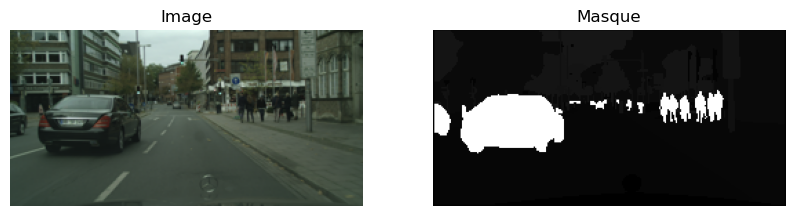

In [35]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

# Chemins des images redimensionnées pour l'entraînement et la validation
train_images_dir_left = "/Users/kevinroualec/Desktop/imgp8/resized_images"
train_images_dir_gtfine = "/Users/kevinroualec/Desktop/imgp8/resized_images"
val_images_dir_left = "/Users/kevinroualec/Desktop/imgp8/leftImg8bit/val"
val_images_dir_gtfine = "/Users/kevinroualec/Desktop/imgp8/gtFine/val"

# Fonction pour charger les images et les labels
def load_image(image_path):
    img = image.load_img(image_path, target_size=(128, 256))  # S'assurer que la taille correspond
    img = image.img_to_array(img)
    return img

# Fonction pour charger les masques (en supposant que ce sont des images)
def load_mask(mask_path):
    img = image.load_img(mask_path, target_size=(128, 256), color_mode="grayscale")  # Chargement en niveaux de gris
    img = image.img_to_array(img)
    return img

# Fonction pour afficher une image et son masque
def display_image_and_mask(image, mask):
    # Si l'image est en format (canaux, hauteur, largeur), on doit la convertir en (hauteur, largeur, canaux)
    if image.shape[0] == 3:  # Si l'image a 3 canaux, c'est le cas pour une image RGB
        image = np.transpose(image, (1, 2, 0))  # Changer la forme de (3, 128, 256) à (128, 256, 3)
    
    # Clipping de l'image et du masque dans une plage valide pour imshow
    image = np.clip(image, 0, 255) / 255.0  # Normalisation de l'image entre 0 et 1
    mask = np.clip(mask, 0, 255)  # Pour le masque, on ne normalise pas, on s'assure juste que les valeurs sont dans la plage correcte

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image)
    axes[0].set_title('Image')
    axes[0].axis('off')
    axes[1].imshow(mask, cmap='gray')  # Affichage en niveaux de gris pour le masque
    axes[1].set_title('Masque')
    axes[1].axis('off')
    plt.show()

# Classe pour le générateur personnalisé
class CustomImageGenerator:
    def __init__(self, image_paths, labels, batch_size, augment=False):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.augment = augment
        # Si l'augmentation est activée, on définit les transformations
        if augment:
            self.augmentation = A.Compose([
                A.RandomCrop(width=256, height=128),
                A.HorizontalFlip(),
                A.RandomBrightnessContrast(),
                ToTensorV2()
            ])
        else:
            self.augmentation = None
        self.indexes = np.arange(len(self.image_paths))
        
    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = [load_image(self.image_paths[i][0]) for i in batch_indexes]
        batch_masks = [load_mask(self.image_paths[i][1]) for i in batch_indexes]
        
        batch_images = np.array(batch_images)
        batch_masks = np.array(batch_masks)
        
        # Si l'augmentation est activée, on applique la transformation
        if self.augment:
            augmented = [self.augmentation(image=img)['image'] for img in batch_images]
            batch_images = np.array(augmented)
        
        return batch_images, batch_masks

# Fonction pour récupérer les images et les labels
def get_image_paths_and_labels(images_dir_left, images_dir_gtfine):
    image_paths = []
    labels = []  # Liste pour stocker les labels
    
    # Parcours des images left et gtFine
    for image_name in os.listdir(images_dir_left):
        if image_name.endswith(('.png', '.jpg', '.jpeg')):  # Ajustement du filtre pour inclure d'autres formats
            # Extraire le préfixe en utilisant les 2 premiers éléments du nom
            prefix = "_".join(image_name.split('_')[:2])
            left_image_path = os.path.join(images_dir_left, image_name)
            
            # On cherche un fichier gtFine correspondant
            gtFine_image_path = None
            for gt_file in os.listdir(images_dir_gtfine):
                if gt_file.startswith(prefix) and 'gtFine_instanceIds' in gt_file:
                    gtFine_image_path = os.path.join(images_dir_gtfine, gt_file)
                    break
            
            # Si on a trouvé une correspondance
            if gtFine_image_path:
                image_paths.append((left_image_path, gtFine_image_path))
                labels.append(prefix)  # Ajouter le label associé
                
    return image_paths, labels  # Retourne maintenant aussi les labels

# Récupérer les chemins des images et labels pour l'entraînement
train_image_paths, train_labels = get_image_paths_and_labels(train_images_dir_left, train_images_dir_gtfine)
# Récupérer les chemins des images et labels pour la validation
val_image_paths, val_labels = get_image_paths_and_labels(val_images_dir_left, val_images_dir_gtfine)

# Création des générateurs de données
train_generator = CustomImageGenerator(train_image_paths, train_labels, batch_size=32, augment=True)
val_generator = CustomImageGenerator(val_image_paths, val_labels, batch_size=32, augment=False)

# Vérification du batch (juste pour s'assurer que tout fonctionne correctement)
for images, masks in train_generator:
    # Sélectionner une seule image et son masque
    selected_image = images[0]
    selected_mask = masks[0]  # Le masque est maintenant l'image correspondante
    
    # Afficher l'image et le masque
    display_image_and_mask(selected_image, selected_mask)
    break  # Quitter après le premier batch
